# Metrics

## Downloads and instalation

In [1]:
!pip install opencv-python==4.5.4.58
!pip install roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 12.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 263.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.1 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=d67d635c9523b16ab8f05fb75d1fa18cda300110b48b13a936081bef97b4d659
  Stored in directory: /roo

In [2]:
from roboflow import Roboflow

# Initialize Roboflow API and download test set
rf = Roboflow(api_key="wSbYaczzLzELee2lx4ed")
project = rf.workspace("crime-detection-zbmr9").project("knifes-and-guns")
dataset = project.version(6).download("voc")

loading Roboflow workspace...
loading Roboflow project...
Exporting format voc in progress : 85.0%
Version export complete for voc format

Extracting Dataset Version Zip to Knifes-and-guns-6 in voc:: 100%|██████████| 18253/18253 [00:04<00:00, 3834.63it/s]


In [3]:
!mv -v Knifes-and-guns-6 Dataset

renamed 'Knifes-and-guns-6' -> 'Dataset'


## Class test

In [4]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, average_precision_score
from roboflow import Roboflow
from tqdm import tqdm
from statistics import mean 

class Test_evaluation:
    test_path = '/content/Dataset/test'
    true_labels = []
    predicted_labels = []

    def __init__(self, model):
        self.model = model

    def evaluate(self, predict=None):
        predict = predict or self.model.predict
        for image_file in tqdm(os.listdir(self.test_path), desc='Testing model', total=len(os.listdir(self.test_path))):
            image_path = os.path.join(self.test_path, image_file)
            if image_file.endswith(".jpg"):
                # Read image and annotations
                annotation_file = os.path.join(self.test_path, f"{image_file[:-4]}.xml")
                with open(annotation_file) as f:
                    annotation_text = f.read()

                # Make predictions and append labels to arrays
                predictions = predict(image_path, confidence=40, overlap=30).json()['predictions']
                predicted_classes = [prediction["class"] for prediction in predictions]

                true_classes = [obj.find('name').text for obj in ET.fromstring(annotation_text).findall('object')]
                
                if len(true_classes) < len(predicted_classes):
                    true_classes += [''] * (len(predicted_classes) - len(true_classes))
                else:
                    predicted_classes += [''] * (len(true_classes) - len(predicted_classes))

                self.true_labels.extend(true_classes)
                self.predicted_labels.extend(predicted_classes)
        
        # Calculate evaluation metrics
        self.precision, self.recall, self.f1_score, _ = precision_recall_fscore_support(self.true_labels, self.predicted_labels)
        self.mAP = average_precision_score(pd.get_dummies(self.true_labels, drop_first=True).values, pd.get_dummies(self.predicted_labels, drop_first=True).values, average='macro')
        self.confusion = confusion_matrix(self.true_labels, self.predicted_labels)

    def plot_confusion_matrix(self):
        # Plot confusion matrix as a heatmap
        fig, ax = plt.subplots(figsize=(5, 4))
        sns.heatmap(self.confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Nothing detected','pistols','knives'], yticklabels=['Nothing detected','pistols','knives'], ax=ax)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.show()

    def __str__(self):
        metrics = pd.DataFrame({
            "Precision": self.precision,
            "Recall": self.recall,
            "F1-score": self.f1_score,
        }, index=['Nothing detected','pistols','knives'])

        st = ''
        st += str('-'*8) + 'Pandas table' + str('-'*8) + '\n'
        st += str(metrics.iloc[1:]) + '\n'
        st += '\n'

        st += str('-'*8) + 'Model metrics' + str('-'*8) + '\n'
        st += "mAP: " + str(self.mAP) + '\n'
        st += "Precision: " + str(mean(metrics['Precision'][1:])) + '\n'
        st += "Recall: " + str(mean(metrics['Recall'][1:])) + '\n'
        st += "F1-score: " + str(mean(metrics['F1-score'][1:])) + '\n'
        st += '\n'

        return st


## Roboflow trained model

Testing model: 100%|██████████| 1830/1830 [02:50<00:00, 10.76it/s]

--------Pandas table--------
         Precision    Recall  F1-score
pistols   0.984668  0.887865  0.933764
knives    0.967153  0.807927  0.880399

--------Model metrics--------
mAP: 0.8960935879308772
Precision: 0.9759105435282707
Recall: 0.8478958263084935
F1-score: 0.907081403399546




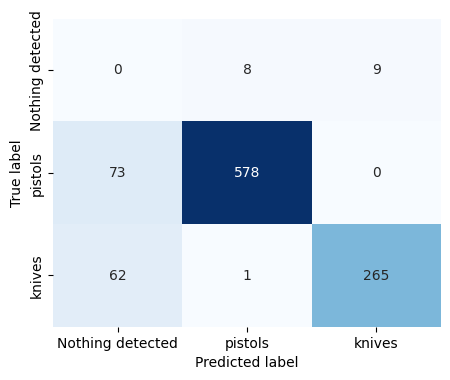

In [5]:
model = project.version(4).model
test_model_1 = Test_evaluation(model)
test_model_1.evaluate()
print(test_model_1)
test_model_1.plot_confusion_matrix()